# Chapter 5 
# INTEGRALS AND DERIVATIVES

## Trapezoidal Rule

In [2]:
function trpzsum(f::Function,a::Real,b::Real,divs::Int)
    sum = -(f(b)-f(a))/2.0
    for x in linspace(a,b,divs)
        sum += f(x)
    end
    sum *= (b-a)/divs
    return sum
end

trpzsum (generic function with 1 method)

In [7]:
@time let a = 0.0, b = pi, divisions = 50, f(x) = sin(x)
    trpzsum(f,a,b,divisions)
end

1.9593285523375812

0.007370 seconds (631 allocations: 31.024 KB)


## Simpson Rule

In [4]:
function smpsonsum(f::Function,a::Real,b::Real,divs::Int)
    x = linspace(a,b,divs)
    oddSum = evenSum = 0
    for k = 1:divs-1
        if isodd(k)
            oddSum += f(x[k])
        else
            evenSum += f(x[k])
        end
    end
        
    return (f(b)+f(a)+4*oddSum+2*evenSum)*(b-a)/(3*divs)
end
        

smpsonsum (generic function with 1 method)

In [6]:
@time let a = 0.0, b = pi, divisions = 50, f(x) = sin(x)
    smpsonsum(f,a,b,divisions)
end

1.9593285523375812

0.006084 seconds (629 allocations: 30.993 KB)


## Adaptive trapezoidal rule

In [67]:
function oddsum(f::Function,a::Real,b::Real,divs::Int)
    sum = 0
    for x in linspace(a,b,divs)[2:2:end-1]
        sum += f(x)
    end
    return sum
end

function adaptivetrpz(f::Function,a::Real,b::Real;ɛ::Float64 = 1e-4)
    divs = 32
    itermax = 20
    
    divmax = divs*2^itermax
    
    I = trpzsum(f,a,b,divs)
    
    divs *= 2
    J = I/2.0 + oddsum(f,a,b,divs)*(b-a)/divs
    
    while abs(I-J)/3.0 > ɛ
        
        if divs > divmax
            warn("Maximum number of iterations reached")
            break
        end
        
        I, J = J, I

        divs *= 2
        J = I/2.0 + oddsum(f,a,b,divs)*(b-a)/divs

    end
    
    return I, abs(I-J)/3.0
end

adaptivetrpz (generic function with 1 method)

In [69]:
@time let a = 0.0, b = pi, f(x) = sin(x)
    adaptivetrpz(f,a,b)
end

(1.9996313775496135,5.6350748211420054e-5)

0.046073 seconds (205.74 k allocations: 3.444 MB)


## Adaptive Simpson rule

In [70]:
function evensum(f::Function,a::Real,b::Real,divs::Int)
    sum = 0
    for x in linspace(a,b,divs)[1:2:end]
        sum += f(x)
    end
    return sum
end

function adaptivesmps(f::Function,a::Real,b::Real;ɛ::Float64 = 1e-4)
    divs = 32
    itermax = 20
    
    divmax = divs*2^itermax
    
    S = evensum(f,a,b,divs)/3
    R = oddsum(f,a,b,divs)*2/3
    I = (S+R)*(b-a)/divs
    
    divs *= 2
    S += R
    T = oddsum(f,a,b,divs)*2/3
    J = (S+T)*(b-a)/divs
    
    while abs(I-J)/15 > ɛ

        if divs > divmax
            warn("Maximum number of iterations reached")
            break
        end
        
        T, R = R, T
        I, J = J, I
        
        divs *= 2
        S += R
        T = oddsum2(f,a,b,divs)
        J = (S+T)*(b-a)/divs
        
    end
    
    return J, abs(I-J)/15
end

adaptivesmps (generic function with 1 method)

In [71]:
@time let a = 0.0, b = pi, f(x) = sin(x)
    adaptivesmps(f,a,b)
end

(1.9990074440702919,6.413586457264901e-5)

0.044392 seconds (207.69 k allocations: 3.542 MB)


## Romberg Integration

In [63]:
function romberg(f::Function, a::Real, b::Real; ɛ::Float64 = 1e-4)
    divs = 32
    itermax = 20 # 32 * 2^20 ≈ 3 10^6 maximum divisions

    R = Array(Float64,itermax,itermax)
    
    R[1,1] = trpzsum(f,a,b,divs)
    
    n = 2
    divs *= 2
    R[2,1] = trpzsum(f,a,b,divs)
    R[2,2] = R[1,1] + abs(R[2,1]-R[1,1])/15    
    
    while abs((R[n,n]-R[n-1,n-1])) > ɛ

        if n >= itermax
            warn("Maximum number of iterations reached")
            break
        end
        
        n += 1
        divs *= 2
        R[n,1] = trpzsum(f,a,b,divs)
        for i = 2:n
            R[n,i] = R[n,i-1] + (R[n,i-1]-R[n-1,i-1])/(4^(i-1)-1)
        end
    end
    
    return R[n,n], (R[n,n]-R[n-1,n-1])
end

romberg (generic function with 1 method)

In [64]:
@time let a = 0.0, b = float(pi), f(x) = sin(x)
    romberg(f,a,b)
end

(1.999925640810088,7.435975587100074e-5)

0.081336 seconds (116.58 k allocations: 2.353 MB)


#### Exercise 5.4 The diffraction limit of a telescope

In [24]:
using PyPlot
const M_PI = Float64(pi)

3.141592653589793

In [28]:
function besselJ(j::Int,x::Float64;divs::Int=99)
    f(j::Int,θ::Float64) = cos(j*θ-x*sin(θ))
    return smpsonsum(x->f(j,x),0.0,M_PI,divs)/M_PI
end

besselJ (generic function with 1 method)

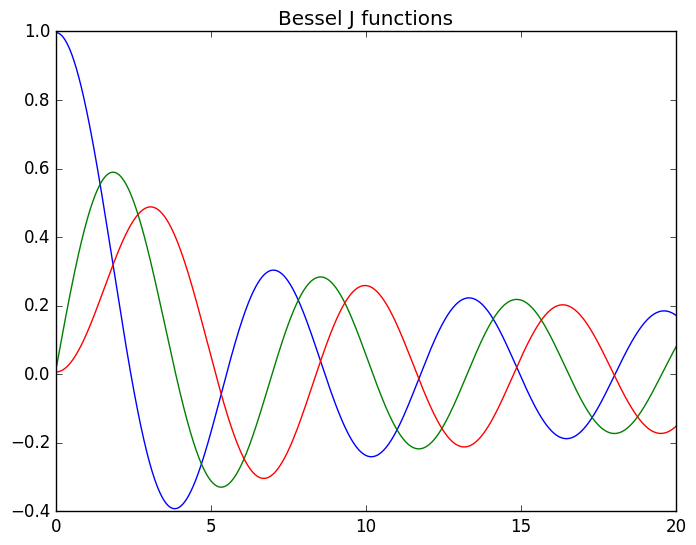

In [29]:
x = linspace(0.0,20.0,1000)
figure("bessel_functions")
title("Bessel J functions")
for i=0:2
    plot(x,map(x->besselJ(i,x),x))
end
plt[:close]()

In [30]:
function intensity(x::Float64,y::Float64; k::Float64=1.0)  
    r = sqrt(x^2+y^2)
    return (besselJ(1,k*r)/(k*r))^2
#    return (besselj1(k*r)/(k*r))^2
end

intensity (generic function with 1 method)

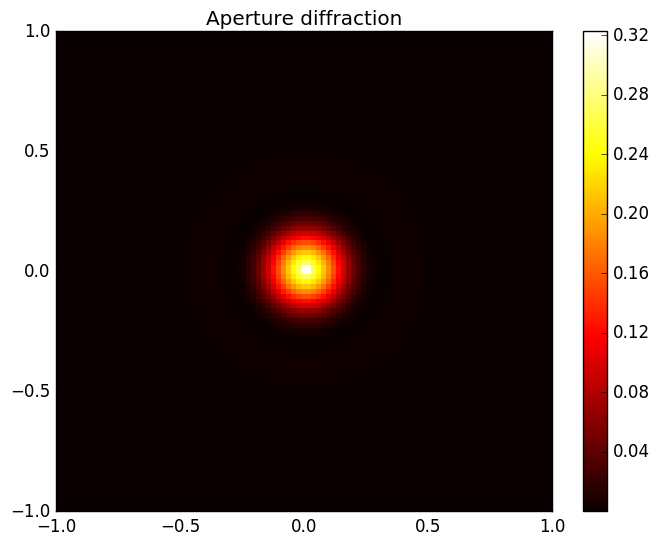

2.143432 seconds (3.30 M allocations: 56.996 MB, 0.80% gc time)


In [31]:
let l = 1.0, divs = 100
    x = repmat(linspace(-l,l,divs),1,divs)
    z = map((x,y) -> intensity(x,y,k=4*M_PI),x,transpose(x))
    figure("density_plot")
    pcolormesh(x,transpose(x),z,cmap="hot")
    colorbar()
    title("Aperture diffraction")
    plt[:close]()
end

#### Exercise 5.4 The diffraction limit of a telescope (using native functions)

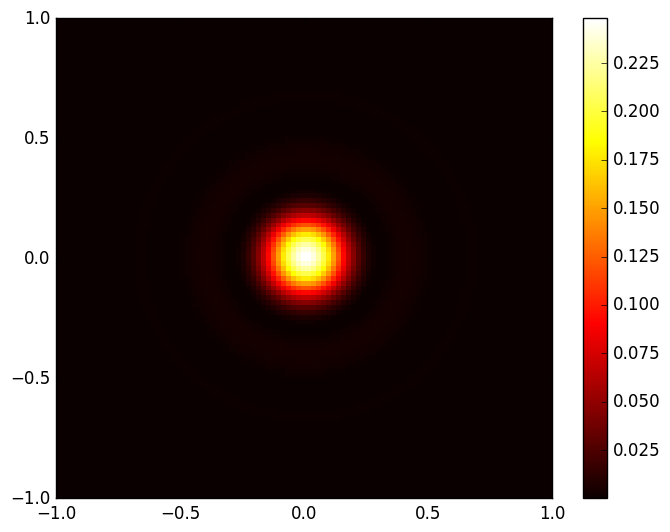

  1.733570 seconds (1.21 k allocations: 959.359 KB, 0.12% gc time)


In [36]:
@time let sidel=1, pts = 100, k = 4*M_PI
    x = repmat(linspace(-sidel,sidel,pts),1,pts)
    y = transpose(x)
    z = (ξ = k*sqrt(x.^2+y.^2); (besselj1(ξ)./ξ).^2)
    pcolormesh(x,y,z,cmap="hot")
    colorbar()
    show()
end